In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import gensim
import pyLDAvis.gensim
import logging
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import time
from pprint import pprint

In [2]:
data = pd.read_csv("./modi_data/eng_full.csv") ############
#data = data.drop(['Unnamed: 0'], axis=1)
data.head()

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,no,year,title,eng_full
0,1,2021.0,Social–Emotional Characteristics and Adjustmen...,Social–Emotional Characteristics and Adjustmen...
1,2,2021.0,Do Mass Media Shape Stereotypes About Intellec...,Do Mass Media Shape Stereotypes About Intellec...
2,3,2021.0,College Choice: Considerations for Academicall...,College Choice: Considerations for Academicall...
3,4,2021.0,Intellectual Precocity: What Have We Learned S...,Intellectual Precocity: What Have We Learned S...
4,5,2021.0,Assessing the Scholarly Reach of Terman's Work,Assessing the Scholarly Reach of Terman's Work...


In [3]:
dfWordList = pd.read_excel("./modi_data/nltk_word_cor.xlsx")
dfWordDel = dfWordList[dfWordList["correction"] == "delete"]
dfWordMod = dfWordList[dfWordList["correction"] != "delete"]

seriesDelete = dfWordDel["word"]
stopword = []
for word in seriesDelete.values:
    stopword.append(word)
#print(stopword)

seriesModify = dfWordMod["word"]
modiword = []
for word in seriesModify.values:
    modiword.append(word)
#print(len(modiword))

seriesModify2 = dfWordMod["correction"]
modiword2 = []
for word in seriesModify2.values:
    modiword2.append(word)
#print(len(modiword2))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
stop_word = set(stopword + stopwords.words('english') + list(string.punctuation))
#print(stop_word)

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def nltkTokenizer(raw, stopword=stop_word):
    list = []

    for word in word_tokenize(raw): #raw data
        #print(word)
        wl = word.lower()
        if wl not in stopword and len(word) > 1:
            if wl in modiword:
                wl = modiword2[modiword.index(wl)].lower()
            list.append(wl)            
    return list

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
tokenized = data["eng_full"].apply(lambda row: nltkTokenizer(row))
#print(tokenized)
print("========= tokenization completed =========")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
========= tokenization completed =========


In [7]:
#lda
id2word = gensim.corpora.Dictionary(tokenized)

wordlist = []
for i in range(len(id2word)):
    #print(id2word[i])
    wordlist.append(id2word[i])
#print(wordlist)
seriesWordlist = pd.Series(wordlist)

corpus=[id2word.doc2bow(text) for text in tokenized]
#print("id2word for each document : ", corpus)
print("# words in total : ", len(id2word))
print("# documents : ", len(corpus))

# words in total :  9699
# documents :  2537
/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexity_values = []
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
        model_list.append(model)
        perplexitymodel = model.log_perplexity(corpus)
        perplexity_values.append(perplexitymodel)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, perplexity_values, coherence_values

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
start = time.time()
model_list, perplexity_values, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=tokenized,
                                                        start=2,
                                                        limit=31, #####
                                                        step=1)
print("time : ", ( time.time() - start )/60, "min")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
time :  7.068094964822134 min


/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


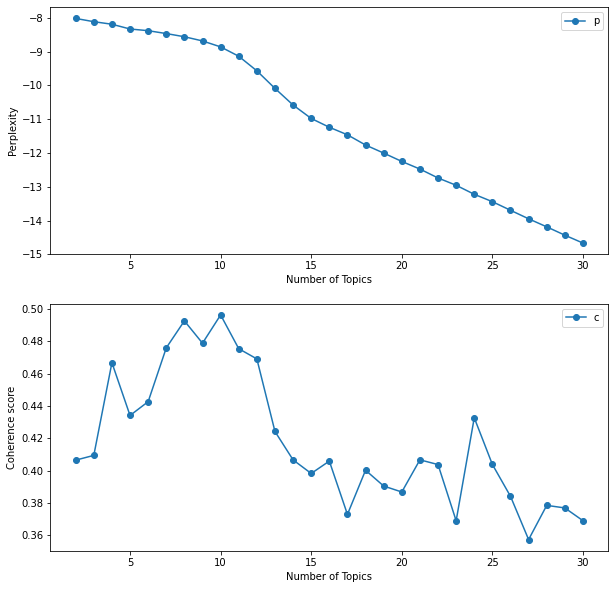

In [10]:
limit=31 ######
start=2
step=1
x = range(start, limit, step)


fig, ax = plt.subplots(2,1, figsize=(10, 10))

ax[0].plot(x, perplexity_values, marker='o')
ax[0].set_xlabel("Number of Topics")
ax[0].set_ylabel("Perplexity")
ax[0].legend(("perplexity"), loc='best')

ax[1].plot(x, coherence_values, marker='o')
ax[1].set_xlabel("Number of Topics")
ax[1].set_ylabel("Coherence score")
ax[1].legend(("coherence_values"), loc='best')
plt.show()

In [11]:
for m, pv in zip(x, perplexity_values):
  print("Num Topics =", m, " has Perplexity Value of", round(pv, 4))

for m, cv in zip(x, coherence_values):
  print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Perplexity Value of -8.0168
Num Topics = 3  has Perplexity Value of -8.1136
Num Topics = 4  has Perplexity Value of -8.1887
Num Topics = 5  has Perplexity Value of -8.33
Num Topics = 6  has Perplexity Value of -8.3797
Num Topics = 7  has Perplexity Value of -8.4649
Num Topics = 8  has Perplexity Value of -8.5589
Num Topics = 9  has Perplexity Value of -8.6832
Num Topics = 10  has Perplexity Value of -8.8595
Num Topics = 11  has Perplexity Value of -9.136
Num Topics = 12  has Perplexity Value of -9.5682
Num Topics = 13  has Perplexity Value of -10.0887
Num Topics = 14  has Perplexity Value of -10.581
Num Topics = 15  has Perplexity Value of -10.9785
Num Topics = 16  has Perplexity Value of -11.239
Num Topics = 17  has Perplexity Value of -11.4626
Num Topics = 18  has Perplexity Value of -11.7649
Num Topics = 19  has Perplexity Value of -12.0038
Num Topics = 20  has Perplexity Value of -12.2511
Num Topics = 21  has Perplexity Value of -12.477
Num Topics = 22  has Perp

In [12]:
a = int(input("set the number of topics "))
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=a,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[(0,
  '0.053*"college" + 0.011*"elementary-school" + 0.007*"executive" + '
  '0.007*"seniors" + 0.006*"evaluating" + 0.005*"like" + 0.004*"1966" + '
  '0.004*"questionnaire" + 0.004*"achievements" + 0.004*"director" + '
  '0.004*"1967" + 0.003*"hunter" + 0.003*"cost" + 0.003*"increasing" + '
  '0.003*"ohio" + 0.003*"perfectionism" + 0.002*"secondary-school" + '
  '0.002*"identity" + 0.002*"contributing" + 0.002*"ten" + 0.002*"judgment" + '
  '0.002*"win" + 0.002*"preparatory" + 0.002*"equal" + 0.002*"cultures" + '
  '0.002*"attend" + 0.002*"october" + 0.002*"happenings" + 0.002*"marriage" + '
  '0.002*"differently"'),


In [13]:
title = input("set the title of html file ")
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, title+".html")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# topic proportion
# num of optimal topics = 8

proportion = []
for i, row_list in enumerate(optimal_model[corpus]):
    #print("document number : ", i)
    row = row_list[0]
    #print(row)
    proportion.append(row)
print(pd.DataFrame(proportion))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
                      0                 1                 2                 3  \
0       (1, 0.05753986)   (2, 0.13709822)  (3, 0.013964497)   (4, 0.07106566)   
1       (1, 0.43811882)  (2, 0.049217153)  (4, 0.043191906)   (5, 0.44863784)   
2        (0, 0.1791867)  (1, 0.019803876)    (2, 0.1549623)   (3, 0.03305085)   
3       (2, 0.19608517)  (3, 0.025551215)   (4, 0.03689302)   (5, 0.65371776)   
4       (1, 0.08830982)   (2, 0.18452863)   (4, 0.02530056)    (5, 0.6809176)   
...                 ...               ...               ...               ...   
2532   (0, 0.014308738)   (1, 0.09040814)   (2, 0.36441103) 

In [16]:
proportion = []
for i, row_list in enumerate(optimal_model[corpus]):
    #print("document number : ", i)
    row = row_list[0]
    #print(row)
    inner_proportion = ["-", "-", "-", "-", "-", "-", "-", "-"] # numtopics 8
    for j, (topic_num, prop) in enumerate(row):
        for k in range(8): # numtopics 8
            if topic_num == k:
                inner_proportion[k] = prop
    proportion.append(inner_proportion)
    #print(inner_proportion)

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
topic_proportions = pd.concat([data["title"], pd.DataFrame(proportion)], axis=1)
topic_proportions.columns = ["Title", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7"] #num topics = 8
print(topic_proportions)
topic_proportions.to_excel("./final_data/0121_topic_proportions_nltk_total.xlsx")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
                                                  Title        T0        T1  \
0     Social–Emotional Characteristics and Adjustmen...         -  0.057540   
1     Do Mass Media Shape Stereotypes About Intellec...         -  0.438119   
2     College Choice: Considerations for Academicall...  0.179187  0.019804   
3     Intellectual Precocity: What Have We Learned S...         -         -   
4        Assessing the Scholarly Reach of Terman's Work         -  0.088310   
...                                                 ...       ...       ...   
2532                         The Gifted Child in France  0.014309  0.09040